# 2.2 - Clasificación (se busca una clase)



### Regresión Logística   (SoftMax)


**Con datos del MNIST, clasificación de números escritos a mano. (1vsALL)**


![sig_plot](images/sig_plot.png)


##### Versión Custom

In [1]:
import time                                                 # para tiempo
inicio=time.time()                                          # momento inicial

print ('Comenzando...\n')
print ('Modelo SoftMax (MLR) : Numeros')    
import pandas as pd                                         # dataframe
import numpy as np                                          # numerical python, algebra lineal

import matplotlib.pyplot as plt                             # plots, graficos
import seaborn as sns                                       # plots

from sklearn.metrics import confusion_matrix                # metricas, matriz de confusion
from scipy.optimize import minimize                         # minimizar, opt

from sklearn.datasets import make_circles, load_boston      # datasets
from sklearn.model_selection import train_test_split as tts

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings                                             # avisos
warnings.filterwarnings('ignore', category=RuntimeWarning)  # elimino un warning por valores NaN en logaritmos o /0

Comenzando...

Modelo SoftMax (MLR) : Numeros


**Se crean las funciones de las ecuaciones principales del modelo.**

![sigmoide](images/sigmoide.png)

In [2]:
def f(X,a):                                 # funcion logistica, sigmoide, funcion del modelo, con z=X*alfa, el producto escalar
    return 1.0/(1.0+np.exp(-np.dot(X,a)))   # Boltzmann con pivote, alfa[i]=0

![coste](images/coste.png)

In [3]:
def coste(X,a,y,lambda_reg):              # funcion coste, funcion a minimizar 
    return -(np.sum(np.log(f(X,a)))+np.dot((y-1).T,(np.dot(X,a))))/y.size + lambda_reg/(2.0*y.size)*np.dot(a[1:],a[1:])

![grad_coste](images/grad_coste.png)

In [4]:
def grad_coste(X,a,y,lambda_reg):          # gradiente de la funcion coste con regularizacion
    return (np.dot(X.T,(f(X,a)-y)))/y.size + lambda_reg/(2.0*y.size)*np.concatenate(([0], a[1:])).T

**Para normalizar los datos.**

In [5]:
def normalizador(X):                # normalizador de X
    X_media=X.mean(axis=0)          # media de X
    X_std=X.std(axis=0)             # desviacion estandar de X
    X_std[X_std==0]=1.0             # si hay alguna std=0 ponla a 1
    X=(X-X_media)/X_std             # normaliza
    
    X=np.insert(X, 0, 1, axis=1)    # esta linea añade una columna de 1, feature engineering [1, f1, f2.., fn, f1f2...] (mejora un 10%)
    
    return X

**Se cargan los datos.**

In [26]:
datos=pd.read_csv('../data/train_Mnist.csv')        # imagenes de numeros
print ('Datos leidos...')
display(datos.head())
matriz_datos=datos.values   
print ('Dimensiones matriz de datos: {}'.format(matriz_datos.shape))   

Datos leidos...


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Dimensiones matriz de datos: (42000, 785)


**Se visualiza una de las imagenes**

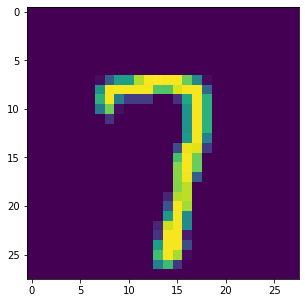

In [34]:
plt.figure(figsize=(5,5))
plt.imshow(matriz_datos[103,1:].reshape(28,28))  
plt.show()

**Creacion de la matriz Y (variable dependiente, a predecir), (onehot)**

In [8]:
Y=np.zeros((matriz_datos.shape[0],10))   
print ('Dimension de Y: {}'.format(Y.shape))  
print ('')
for i in range(10):
    Y[:,i]=np.where(matriz_datos[:,0]==i,1,0)
print(Y[0:10,:]) # 10 primeras filas

Dimension de Y: (42000, 10)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


**Se separan las columnas etiqueta y se quitan las columnas que sean todo ceros.**

In [9]:
etiquetas=matriz_datos[:,0]        # etiqueta, el numero en si, 42000 etiquetas
X=matriz_datos[:,1:]               # datos numericos de los pixeles, cada columna es un pixel (variables indep)
print ('Dimension original de X: {}'.format(X.shape)) 
print ('')
X=X[:,X.sum(axis=0)!=0]            # se quitan las columnas=0 (la suma de los elementos es no nulo, no hay informacion)
print ('Dimension limpia de X: {}'.format(X.shape)) 

Dimension original de X: (42000, 784)

Dimension limpia de X: (42000, 708)


**Se dividen los datos en train y test.**

In [10]:
X_train, Y_train=X[0:30000,:], Y[0:30000,:]        # datos de entranamiento
X_train_sk=X_train.copy()                          # para sklearn

X_test, Y_test=X[30000:,:], Y[30000:,:]            # datos de test
X_test_sk=X_test.copy()                            # para sklearn

print ('Dimensiones train: X={}, Y={}'.format(X_train.shape, Y_train.shape))  
print ('')
print ('Dimensiones test: X={}, Y={}'.format(X_test.shape, Y_test.shape))

Dimensiones train: X=(30000, 708), Y=(30000, 10)

Dimensiones test: X=(12000, 708), Y=(12000, 10)


**Etiquetas train y test.**

In [11]:
etiquetas_train=etiquetas[0:30000]       # etiquetas para entranamiento
etiquetas_test=etiquetas[30000:]         # etiquetas para test

print ('Dimensiones etiquetas train: {}'.format(etiquetas_train.shape))
print ('')
print ('Dimensiones etiquetas test: {}'.format(etiquetas_test.shape))

Dimensiones etiquetas train: (30000,)

Dimensiones etiquetas test: (12000,)


**Normaliza los datos.**

In [12]:
X_train=normalizador(X_train)
X_test=normalizador(X_test)
print ('Datos normalizados.')

Datos normalizados.


**Se buscan los parametros optimos para los 10 modelos.**

In [13]:
val_inicial=np.random.rand(X_train.shape[1]) # valores iniciales de los parametros alfa

A_opt=np.zeros((X_train.shape[1],10))        # se crea la matriz para los parametros optimizados, alfas

**Término de regularización L2.**

In [14]:
lambda_reg=100.            # valor obtenido desde gridsearching  

**Optimización.**

In [15]:
inicio_opt=time.time()                       # inicio optimizacion

for i in range(10):
    print ('\n\nOptimizando {} frente al resto.'.format(i))

    def opt_coste(a):                        # funcion a minimizar
        return coste(X_train, a, Y_train[:,i], lambda_reg) 

    def opt_grad_coste(a):                   # gradiente 
        return grad_coste(X_train, a, Y_train[:,i], lambda_reg)

    # metodo Nelder-Mead, Powell, CG, BFGS, Newton-CG, L-BFGS-B, TNC, COBYLA, SLSQP, trust-constr, 
    # dogleg, trust-ncg, trust-exact, trust-krylov (tambien custom)            
    metodo='trust-constr'
    
    print ('Optimizacion {}...'.format(metodo)) # minimizacion, optimizacion
    i_opt=time.time() 
    modelo=minimize(opt_coste, val_inicial, method=metodo, jac=opt_grad_coste, tol=1e-4, options={'disp':True}) 
    
    print ('Hecho.')
    print ("Tiempo optimizacion: {:.2f} segundos." .format(time.time()-i_opt))  
    A_opt[:,i]=modelo.x

t_custom=time.time()-inicio_opt   # tiempo desde inicio hasta final minimizacion
print ('\nTiempo total optimizacion custom: {:.2f} segundos.\n' .format(t_custom)) 



Optimizando 0 frente al resto.
Optimizacion trust-constr...
`gtol` termination condition is satisfied.
Number of iterations: 63, function evaluations: 63, CG iterations: 364, optimality: 8.75e-05, constraint violation: 0.00e+00, execution time:  1.4 s.
Hecho.
Tiempo optimizacion: 1.39 segundos.


Optimizando 1 frente al resto.
Optimizacion trust-constr...
`gtol` termination condition is satisfied.
Number of iterations: 64, function evaluations: 64, CG iterations: 324, optimality: 9.99e-05, constraint violation: 0.00e+00, execution time:  1.4 s.
Hecho.
Tiempo optimizacion: 1.39 segundos.


Optimizando 2 frente al resto.
Optimizacion trust-constr...
`gtol` termination condition is satisfied.
Number of iterations: 64, function evaluations: 64, CG iterations: 361, optimality: 9.30e-05, constraint violation: 0.00e+00, execution time:  1.4 s.
Hecho.
Tiempo optimizacion: 1.39 segundos.


Optimizando 3 frente al resto.
Optimizacion trust-constr...
`gtol` termination condition is satisfied.
N

**Ahora se chequea el modelo.**

In [16]:
y_pred=[]                  # etiquetas predichas
y_prob=[]                  # probabilidades de las etiquetas predichas

def resumen(datos):        # testeo
    for e in datos:
        nombre, etiqueta, Xs=e         
        etiq=etiqueta.size
        probs=np.zeros((etiq,2))      # etiquetas con su probabilidad
        cuenta=0                      # conteo de aciertos
        for muestra in range(etiq): 
            for n in range(10):
                alfa=A_opt[:,n]       # parametros de softmax
                probs[n,0]=n
                probs[n,1]=f(Xs[muestra,:],alfa)      # evaluacion de la prediccion
                
            probs=probs[probs[:,1].argsort()[::-1]]   # se pone la prob mas alta al principio
            y_pred.append(probs[0,0])
            y_prob.append(probs[0,1])
            if probs[0,0]==etiqueta[muestra]:         # si se acierta +1
                cuenta+=1
        print ("\n{}".format(nombre))
        print ("{} correctos de {} ==> {:.4}% correcto".format(cuenta, etiq, cuenta/etiq*100))

**Resultados train y test Custom.**

In [17]:
resumen([('Entranamiento  :', etiquetas_train, X_train)])
resumen([('Test  :', etiquetas_test, X_test)])


Entranamiento  :
27954 correctos de 30000 ==> 93.18% correcto

Test  :
10982 correctos de 12000 ==> 91.52% correcto


**Se guarda el entrenamiento, los alfas, en un csv.**

In [18]:
print ('Dimensiones matriz de parametros={}'.format(A_opt.shape))
df=pd.DataFrame(A_opt, columns=[i+1 for i in range(A_opt.shape[1])])  # se guardan los parametros softmax en csv
#df.to_csv('alfas.csv', index=False)

Dimensiones matriz de parametros=(709, 10)


###### Versión SkLearn

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
ini_opt_sk=time.time()

logreg=LogisticRegression(C=0.01,         # es igual a lambda=100, termino de reg
                          penalty='l2',   # regularizacion L2
                          tol=0.0001,     # tolerancia
                          max_iter=70,    # maximo numero de iteraciones
                          solver='lbfgs', # metodo 
                          multi_class='multinomial')

logreg.fit(X_train_sk, etiquetas_train)  # entrenamiento


t_sklearn=time.time()-ini_opt_sk
print ('\nTiempo total optimizacion sklearn: {:.2f} segundos.\n' .format(t_sklearn))


Tiempo total optimizacion sklearn: 2.79 segundos.



/Users/iudh/opt/anaconda3/envs/clase/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Chequeo modelo sklearn.**

In [21]:
def resumen_sk(datos):
    for e in datos:
        nombre, etiqueta, Xs=e
        etiq=etiqueta.size
        
        y_pred_sk=logreg.predict(Xs)
        
        cuenta=0
        for muestra in range(etiq):
            if y_pred_sk[muestra]==etiqueta[muestra]:         
                cuenta+=1
        
        print ("\n{}".format(nombre))
        print ("{} correctos de {} ==> {:.4}% correcto".format(cuenta, etiq, cuenta/etiq*100))

**Resultados train y test Custom.**

In [22]:
resumen_sk([('Entranamiento  :', etiquetas_train, X_train_sk)])
resumen_sk([('Test  :', etiquetas_test, X_test_sk)])


Entranamiento  :
28108 correctos de 30000 ==> 93.69% correcto

Test  :
11014 correctos de 12000 ==> 91.78% correcto


**Comparacion en tiempo**

In [23]:
print ('SkLearn es {:.2f} veces más rapido.'.format(t_custom/t_sklearn))

SkLearn es 4.98 veces más rapido.


**Diferencia absoluta entre ambos modelos.**

In [24]:
y_pred_sk=logreg.predict(X_test_sk)


comp=[y_pred[30000:][i]==y_pred_sk[i] for i in range(len(y_pred[30000:]))]
n_equal=len([e for e in comp if e==False])/len(y_pred_sk)

print ('Hay una diferencia entre ambos modelos del {:.2f}%.'.format(n_equal*100))

Hay una diferencia entre ambos modelos del 4.82%.


**Acierto en train y test de ambos modelos.**

In [25]:
resumen([('Entranamiento Custom:', etiquetas_train, X_train)])
resumen([('Test Custom:', etiquetas_test, X_test)])
print ('')
resumen_sk([('Entranamiento SkLearn:', etiquetas_train, X_train_sk)])
resumen_sk([('Test SkLearn:', etiquetas_test, X_test_sk)])


Entranamiento Custom:
27954 correctos de 30000 ==> 93.18% correcto

Test Custom:
10982 correctos de 12000 ==> 91.52% correcto


Entranamiento SkLearn:
28108 correctos de 30000 ==> 93.69% correcto

Test SkLearn:
11014 correctos de 12000 ==> 91.78% correcto


In [37]:
y_pred[:10]

[1.0, 0.0, 1.0, 4.0, 0.0, 0.0, 7.0, 3.0, 5.0, 3.0]

In [38]:
y_prob[:10]

[0.9901416144450437,
 0.9998897482611364,
 0.9946965670677095,
 0.4581105421177526,
 0.999992816048339,
 0.9124264848954301,
 0.9957379087957117,
 0.9595513813420048,
 0.9001942307357196,
 0.9929913426531387]

In [39]:
logreg.score(X_train_sk, etiquetas_train)  # accuracy, acierto

0.9369333333333333

# Arboles RFC

# SVC